## with Wake Effect

In [1]:

import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from iwopy.interfaces.pymoo import Optimizer_pymoo

from iwopy import LocalFD
from iwopy.optimizers import GG

import foxes
import foxes.variables as FV
from foxes.opt.problems.layout import FarmLayoutOptProblem
from foxes.opt.constraints import FarmBoundaryConstraint, MinDistConstraint, AreaGeometryConstraint
from foxes.opt.objectives import MaxFarmPower
from foxes.opt.objectives import MaxNTurbines  

import foxes.opt.problems.layout.geom_layouts as grg      # Purely geometrical layout problems (wake effects are not evaluated).
# to include Wake effect look up: https://fraunhoferiwes.github.io/foxes.docs/api_opt_problems.html#foxes-opt-problems-layout

from iwopy.interfaces.pymoo import Optimizer_pymoo        # some optimization Package idk
import geopandas as gpd



## Optimze the Layout considering Wake effects

In [2]:
## get timeseries-data (here ERA5 as example)-------
from ERA5 import load_data,calculate_wind_speed,calculate_wind_direction,calculate_averages,check_data_gaps

Era5_path = 'data/reanalysis'  
start_year = 2000
end_year = 2010
    
Era5_data = load_data(Era5_path, start_year, end_year)
Era5_data = calculate_wind_speed(Era5_data)
Era5_data = calculate_wind_direction(Era5_data)
##--------------------------------------------------
data = Era5_data
 
#print(type(data))  
data.columns

c:\Advanced Programming\Project\StudentProject-Yield-Predictions-Offshore\ERA5.py:62: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=Era5_data.index.min(), end=Era5_data.index.max(), freq='H')


Data Availability is 99.97%
Missing time periods are:
DatetimeIndex(['2023-02-26 00:00:00', '2023-02-26 01:00:00',
               '2023-02-26 02:00:00', '2023-02-26 03:00:00',
               '2023-02-26 04:00:00', '2023-02-26 05:00:00',
               '2023-02-26 06:00:00', '2023-02-26 07:00:00',
               '2023-02-26 08:00:00', '2023-02-26 09:00:00',
               '2023-02-26 10:00:00', '2023-02-26 11:00:00',
               '2023-02-26 12:00:00', '2023-02-26 13:00:00',
               '2023-02-26 14:00:00', '2023-02-26 15:00:00',
               '2023-02-26 16:00:00', '2023-02-26 17:00:00',
               '2023-02-26 18:00:00', '2023-02-26 19:00:00',
               '2023-02-26 20:00:00', '2023-02-26 21:00:00',
               '2023-02-26 22:00:00', '2023-02-26 23:00:00',
               '2023-02-27 00:00:00', '2023-02-27 01:00:00',
               '2023-02-27 02:00:00', '2023-02-27 03:00:00',
               '2023-02-27 04:00:00', '2023-02-27 05:00:00',
               '2023-02-27 06:0

Index(['Time [UTC]', 'u100', 'v100', 'u10', 'v10', 'WS100', 'WS10', 'WD100',
       'WD10'],
      dtype='object')

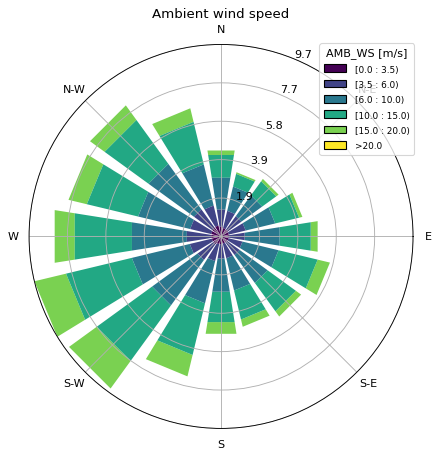

In [3]:
# create the states object and have a look at the wind rose, look at input States 
# Wind and other atmospheric inflow conditions are called `States`
states = foxes.input.states.Timeseries(                           # StatesTable for panda df or pd readable file (single height)
    data_source = data ,                                           # the data
    output_vars = [FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col =     {FV.WS: "WS100", FV.WD: "WD100", FV.TI: "ti"}, # Mapping from variable names to data column names

    fixed_vars =  {FV.RHO: 1.225, FV.TI: 0.05},                  # TI: Turbulenze intensity
)
# Plot windrose
o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

In [4]:
# Some Parameter
N = 10
D = 126
Min_Dist = 3*D

Population  = 20
Generations = 10
Seed        = 42



# initialize Model_book
mbook = foxes.models.ModelBook()
ttype = foxes.models.turbine_types.PCtFile("NREL-5MW-D126-H90.csv")
mbook.turbine_types[ttype.name] = ttype

# Set Boundary
site_shp = gpd.read_file('data/shapefiles/FEP2024_PreDraft/site.shp')
row = site_shp['name_fep']
#GEO_DF = pd.concat([site_shp[row=='N-9.1'] , site_shp[row=='N-9.2'] , site_shp[row=='N-9.3']], ignore_index=True)
__boundary = foxes.utils.geom2d.ClosedPolygon(
        np.array(site_shp[row=='N-9.1'].get_coordinates())
    )
boundary = foxes.utils.geom2d.ClosedPolygon(
        np.array(site_shp[row=='N-9.1'].get_coordinates())-__boundary.p_min()
        )



farm = foxes.WindFarm(boundary=boundary) # initiate frame object

# add Turbines as row
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base= boundary.p_min(), # min ouf boundary
    xy_step=np.array([50.0, 50.0]),
    n_turbines=N,
    turbine_models=[ttype.name],
)

algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="centre",
    wake_models=["Bastankhah025_quadratic_k002"],
    wake_frame="rotor_wd",
    partial_wakes=None,
    mbook=mbook,
    verbosity=0,
)


Turbine 0, T0: NREL-5MW
Turbine 1, T1: NREL-5MW
Turbine 2, T2: NREL-5MW
Turbine 3, T3: NREL-5MW
Turbine 4, T4: NREL-5MW
Turbine 5, T5: NREL-5MW
Turbine 6, T6: NREL-5MW
Turbine 7, T7: NREL-5MW
Turbine 8, T8: NREL-5MW
Turbine 9, T9: NREL-5MW


Problem 'layout_opt' (FarmLayoutOptProblem): Initializing
---------------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 20
---------------------------------------------------------
  n_objectives: 1
  n_obj_cmptns: 1
---------------------------------------------------------
  n_constraints: 2
  n_con_cmptns: 55
---------------------------------------------------------
Loading pymoo
pymoo successfully loaded
Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: GA (GA)
Selecting termination: default (DefaultSingleObjectiveTermination)

Problem:
--------
  vectorize: False

Algorithm:
----------
  type: GA
  pop_size: 20
  seed: 42

Termination:
------------
  n_max_gen: 10
  ftol: 1e-06
  xtol: 1e-06



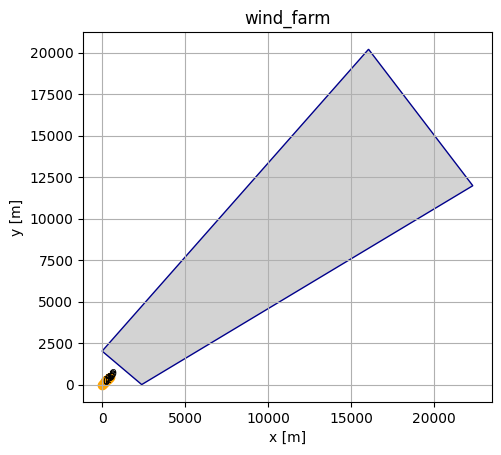

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |  1.564707E+06 |  1.652030E+06 |             - |             -
     2 |       40 |  1.551186E+06 |  1.601687E+06 |             - |             -
     3 |       60 |  1.523758E+06 |  1.572208E+06 |             - |             -
     4 |       80 |  1.514915E+06 |  1.549981E+06 |             - |             -
     5 |      100 |  1.476263E+06 |  1.519555E+06 |             - |             -
     6 |      120 |  1.476263E+06 |  1.500123E+06 |             - |             -
     7 |      140 |  1.464906E+06 |  1.484200E+06 |             - |             -
     8 |      160 |  1.448483E+06 |  1.473334E+06 |             - |             -
     9 |      180 |  1.433719E+06 |  1.456300E+06 |             - |             -
    10 |      200 |  1.429740E+06 |  1.442682E+06 |             - |             -


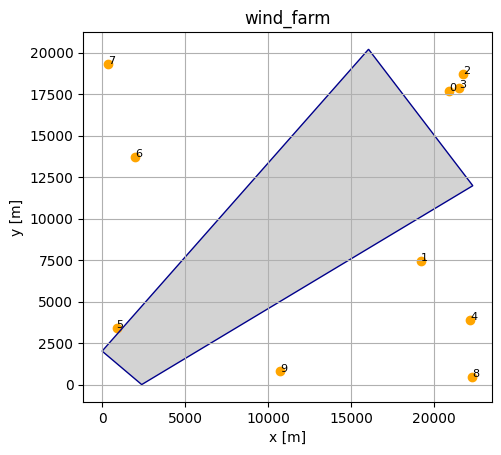

Optimizer_pymoo: Optimization run finished
  Success: False


In [5]:

with foxes.utils.runners.DaskRunner(
    # scheduler=None,
    # n_workers=4,
    # threads_per_worker=1,
    progress_bar=False,   # you can't see convergence with this, stupid
    verbosity=1,          # detail of output
) as runner:
    ###--------------------------The_Problem------------------------------###
    problem = FarmLayoutOptProblem("layout_opt", algo, runner=runner)
    problem.add_objective(MaxFarmPower(problem))
    
    #problem.add_objective(MaxNTurbines(problem))  #to max unmber of turbines
    
    
    # problem.add_constraint(AreaGeometryConstraint(
    #     problem,
    #     geometry = boundary,
    #     name = "steve"
    #     ))
    problem.add_constraint(FarmBoundaryConstraint(problem))

    if Min_Dist is not None:
         problem.add_constraint(
            MinDistConstraint(problem, min_dist=Min_Dist, min_dist_unit="D")
        )
        
    problem.initialize()
    ###--------------------------------------------------------------------###
    
    solver = Optimizer_pymoo(
        problem,
        problem_pars=dict(
            vectorize=not "store_true",
        ),
        algo_pars=dict(
            type="GA",
            pop_size=Population,
            seed=Seed,
        ),
        setup_pars=dict(),
        term_pars=dict(
            type="default",
            n_max_gen=Generations,
            ftol=1e-6,
            xtol=1e-6,
        ),
    )
    solver.initialize()
    solver.print_info()

    ax = foxes.output.FarmLayoutOutput(farm).get_figure()
    plt.show()
    plt.close(ax.get_figure())

    results = solver.solve()
    
    ax = foxes.output.FarmLayoutOutput(farm).get_figure()
    plt.show()
    plt.close(ax.get_figure())
    
    solver.finalize(results)


In [6]:
#----------------------------------

    print()
    print(results)

    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    foxes.output.FarmLayoutOutput(farm).get_figure(fig=fig, ax=axs[0])

    o = foxes.output.FlowPlots2D(algo, results.problem_results)
    p_min = np.array([-100.0, -350.0])
    p_max = np.array([1100.0, 1600.0])
    fig = o.get_mean_fig_xy(
        "WS",
        resolution=20,
        fig=fig,
        ax=axs[1],
        xmin=p_min[0],
        xmax=p_max[0],
        ymin=p_min[1],
        ymax=p_max[1],
    )
    dpars = dict(alpha=0.6, zorder=10, p_min=p_min, p_max=p_max)
    farm.boundary.add_to_figure(
        axs[1], fill_mode="outside_white", pars_distance=dpars
    )

    plt.show()
    plt.close(fig)
    
    
    

IndentationError: unexpected indent (2723323444.py, line 3)